# TCGA-LUSC CT Scan Analysis with TotalSegmentator

This notebook demonstrates how to:
1. Load DICOM files from TCGA dataset
2. Build 3D volumes from CT scans
3. Visualize CT data
4. Perform automatic lung tumor segmentation using TotalSegmentator
5. Extract radiomic features using PyRadiomics

## Step 0: Setup Python 3.10 Virtual Environment

**This cell sets up the entire environment. Run it first!**

In [ ]:
# Install Python 3.10 and create virtual environment
!sudo apt-get update -qq
!sudo apt-get install -y python3.10 python3.10-venv python3.10-distutils git build-essential

# Create virtual environment
!python3.10 -m venv /content/py310env

# Upgrade pip and install all required packages
!/content/py310env/bin/pip install --upgrade pip
!/content/py310env/bin/pip install -q pydicom numpy matplotlib ipywidgets SimpleITK tqdm PyWavelets pylibjpeg

# ================================
# Install PyRadiomics FROM SOURCE
# (Because pip version does NOT support Python 3.10)
# ================================
!git clone https://github.com/Radiomics/pyradiomics.git /content/pyradiomics
%cd /content/pyradiomics

# Install PyRadiomics requirements
!/content/py310env/bin/pip install -r requirements.txt

# Build PyRadiomics C extensions & install
!/content/py310env/bin/python setup.py build_ext --inplace
!/content/py310env/bin/python setup.py install

# ================================
# Install TotalSegmentator (same as before)
# ================================
!/content/py310env/bin/pip install -q git+https://github.com/wasserth/TotalSegmentator.git

# Verify installation
print("\n=== Verification ===")
!/content/py310env/bin/python --version
!/content/py310env/bin/pip list | grep -E "pydicom|pyradiomics|SimpleITK|TotalSegmentator"
print("\n✓ Environment setup complete!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'python3-distutils' instead of 'python3.10-distutils'
build-essential is already the newest version (12.9ubuntu3).
git is already the newest version (1:2.34.1-1ubuntu1.15).
python3-distutils is already the newest version (3.10.8-1~22.04).
python3-distutils set to manually installed.
The following additional packages will be installed:
  libpython3.10 libpython3.10-dev libpython3.10-minimal libpython3.10-stdlib
  python3-pip-whl python3-setuptools-whl python3.10-minimal
Suggested packages:
  python3.10-doc binfmt-support
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
The following packages will be upgraded:
  libpython3.10 libpython3.1

## Step 1: Mount Google Drive and Find DICOM Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Path to your TCGA dataset
DATASET_PATH = "/content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC"

def find_dicom_files(root):
    """Recursively find all DICOM files in directory"""
    dicom_paths = []
    for dirpath, _, filenames in os.walk(root):
        for f in filenames:
            if f.lower().endswith(".dcm"):
                dicom_paths.append(os.path.join(dirpath, f))
    return dicom_paths

dicoms = find_dicom_files(DATASET_PATH)
print(f"Number of DICOM files found: {len(dicoms)}")
if dicoms:
    print(f"Example DICOM: {dicoms[0]}")

Mounted at /content/drive
Number of DICOM files found: 15021
Example DICOM: /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2716/07-01-1996-NA-CT ANGIOGRAPHY CHEST WWO CON-22142/6.000000-HELICAL MODE-98985/1-01.dcm


## Step 2: Load DICOM Series and Build 3D Volume

In [ ]:
# Save the DICOM loading script
script_content = """
import pydicom
import numpy as np
import os
import pickle

def load_dicom_series(folder):
    slices = []
    for f in sorted(os.listdir(folder)):
        if f.lower().endswith(".dcm"):
            path = os.path.join(folder, f)
            try:
                ds = pydicom.dcmread(path)
                if hasattr(ds, 'PixelData'):
                    slices.append(ds)
            except Exception as e:
                print(f"Warning: Could not read {f}: {e}")
                continue

    if len(slices) == 0:
        raise ValueError(f"No valid DICOM slices found in folder: {folder}")

    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    volume = np.stack([s.pixel_array for s in slices]).astype(np.int16)

    for i, s in enumerate(slices):
        intercept = float(s.RescaleIntercept)
        slope = float(s.RescaleSlope)
        volume[i] = volume[i] * slope + intercept

    px_spacing = list(map(float, slices[0].PixelSpacing))

    try:
        z_spacing = abs(
            float(slices[1].ImagePositionPatient[2]) -
            float(slices[0].ImagePositionPatient[2])
        )
    except:
        z_spacing = float(slices[0].SliceThickness)

    spacing = (z_spacing, px_spacing[0], px_spacing[1])
    return volume, spacing, slices

patient_folder = "/content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-2605/08-10-1989-NA-CT CHEST-64467/2.000000-Helical 5s-02217"

print("Loading DICOM series...")
volume, spacing, dicom_slices = load_dicom_series(patient_folder)

print(f"Volume shape: {volume.shape}")
print(f"Number of slices: {len(dicom_slices)}")
print(f"Spacing (z, y, x): {spacing}")
print(f"HU range: [{volume.min()}, {volume.max()}]")

# Save results for use in main notebook
with open('/content/dicom_data.pkl', 'wb') as f:
    pickle.dump({
        'volume': volume,
        'spacing': spacing,
        'num_slices': len(dicom_slices)
    }, f)
"""

with open('/content/load_dicom.py', 'w') as f:
    f.write(script_content)

# Run with Python 3.10 venv
!/content/py310env/bin/python /content/load_dicom.py

# Load results into main notebook
import pickle
with open('/content/dicom_data.pkl', 'rb') as f:
    data = pickle.load(f)
    volume = data['volume']
    spacing = data['spacing']
    num_slices = data['num_slices']

print("\n✓ Data loaded into notebook variables")

Loading DICOM series...
Volume shape: (64, 512, 512)
Number of slices: 64
Spacing (z, y, x): (5.0, 0.78125, 0.78125)
HU range: [-2048, 3071]

✓ Data loaded into notebook variables


## Step 3: Visualize CT Scans

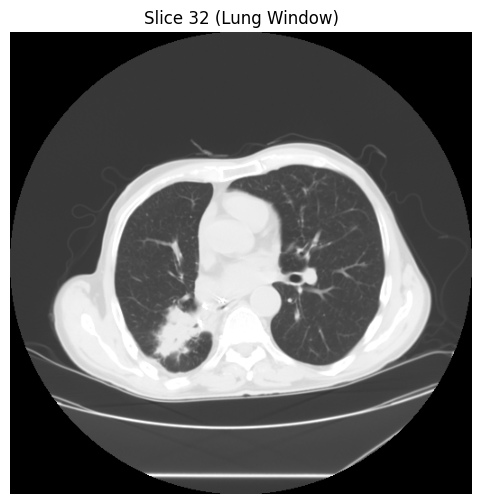

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def window_image(img, window_center=-600, window_width=1500):
    """Apply windowing for better visualization"""
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def show_slice(volume, slice_index=None, window=True):
    """Display a single slice"""
    if slice_index is None:
        slice_index = volume.shape[0] // 2

    img = volume[slice_index]
    if window:
        img = window_image(img)

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.title(f"Slice {slice_index} (Lung Window)")
    plt.axis("off")
    plt.show()

show_slice(volume)

In [ ]:
# Interactive slice viewer
from ipywidgets import interact, IntSlider

def scroll_slices(index):
    plt.figure(figsize=(6, 6))
    plt.imshow(window_image(volume[index]), cmap="gray")
    plt.title(f"Slice {index}/{volume.shape[0]-1}")
    plt.axis("off")
    plt.show()

interact(scroll_slices,
         index=IntSlider(min=0, max=volume.shape[0]-1, step=1, value=volume.shape[0]//2))

interactive(children=(IntSlider(value=32, description='index', max=63), Output()), _dom_classes=('widget-inter…

<function __main__.scroll_slices(index)>

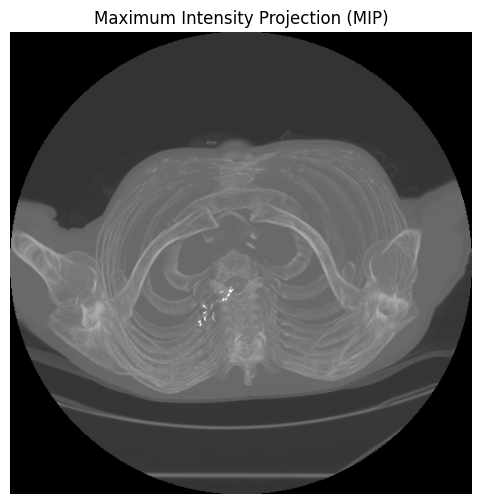

In [ ]:
# Maximum Intensity Projection (MIP)
mip = np.max(volume, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(mip, cmap="gray")
plt.title("Maximum Intensity Projection (MIP)")
plt.axis("off")
plt.show()

## Step 4: Save Volume as NIfTI for TotalSegmentator

In [ ]:
# Save NIfTI using Python 3.10 environment
save_nifti_script = f"""
import SimpleITK as sitk
import pickle

# Load data
with open('/content/dicom_data.pkl', 'rb') as f:
    data = pickle.load(f)

volume = data['volume']
spacing = data['spacing']

# Convert to SimpleITK image
sitk_img = sitk.GetImageFromArray(volume)
sitk_img.SetSpacing(spacing[::-1])  # SimpleITK uses (x,y,z) order

# Save as NIfTI
output_path = "/content/ct_volume.nii.gz"
sitk.WriteImage(sitk_img, output_path)

print(f"✓ Saved NIfTI file: {{output_path}}")
print(f"  Image size: {{sitk_img.GetSize()}}")
print(f"  Spacing: {{sitk_img.GetSpacing()}}")
"""

with open('/content/save_nifti.py', 'w') as f:
    f.write(save_nifti_script)

!/content/py310env/bin/python /content/save_nifti.py

✓ Saved NIfTI file: /content/ct_volume.nii.gz
  Image size: (512, 512, 64)
  Spacing: (0.78125, 0.78125, 5.0)


## Step 5: Run TotalSegmentator for Lung Tumor Detection

In [ ]:
# Run TotalSegmentator using Python 3.10 environment
print("Running TotalSegmentator...")
print("This may take several minutes...\n")

!/content/py310env/bin/TotalSegmentator -i /content/ct_volume.nii.gz -o /content/ts_output --fast

print("\n✓ Segmentation complete!")

Running TotalSegmentator...
This may take several minutes...


If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

TotalSegmentator sends anonymous usage statistics. If you want to disable it check the documentation.
Using 'fast' option: resampling to lower resolution (3mm)
Downloading: 100% 135M/135M [00:00<00:00, 158MB/s]
Download finished. Extracting...
Resampling...
  Resampled in 2.76s
Predicting...
100% 4/4 [00:03<00:00,  1.20it/s]
  Predicted in 27.62s
Resampling...
Saving segmentations...
  Saved in 14.64s

✓ Segmentation complete!


## Step 6: Load and Visualize Tumor Segmentation

In [ ]:
# Check what organs were segmented
import os

output_dir = "/content/ts_output"
if os.path.exists(output_dir):
    segmented_organs = [f.replace('.nii.gz', '') for f in os.listdir(output_dir)
                       if f.endswith('.nii.gz')]
    print("Segmented structures:")
    for organ in sorted(segmented_organs):
        print(f"  - {organ}")
else:
    print("Output directory not found!")

Segmented structures:
  - adrenal_gland_left
  - adrenal_gland_right
  - aorta
  - atrial_appendage_left
  - autochthon_left
  - autochthon_right
  - brachiocephalic_trunk
  - brachiocephalic_vein_left
  - brachiocephalic_vein_right
  - brain
  - clavicula_left
  - clavicula_right
  - colon
  - common_carotid_artery_left
  - common_carotid_artery_right
  - costal_cartilages
  - duodenum
  - esophagus
  - femur_left
  - femur_right
  - gallbladder
  - gluteus_maximus_left
  - gluteus_maximus_right
  - gluteus_medius_left
  - gluteus_medius_right
  - gluteus_minimus_left
  - gluteus_minimus_right
  - heart
  - hip_left
  - hip_right
  - humerus_left
  - humerus_right
  - iliac_artery_left
  - iliac_artery_right
  - iliac_vena_left
  - iliac_vena_right
  - iliopsoas_left
  - iliopsoas_right
  - inferior_vena_cava
  - kidney_cyst_left
  - kidney_cyst_right
  - kidney_left
  - kidney_right
  - liver
  - lung_lower_lobe_left
  - lung_lower_lobe_right
  - lung_middle_lobe_right
  - lung_upper

In [ ]:
# Load segmentation mask using Python 3.10
load_mask_script = """
import SimpleITK as sitk
import numpy as np
import pickle
import os

mask_path = "/content/ts_output/lung_tumor.nii.gz"
mask = None

if os.path.exists(mask_path):
    mask_img = sitk.ReadImage(mask_path)
    mask = sitk.GetArrayFromImage(mask_img)
    print(f"Tumor mask shape: {mask.shape}")
    print(f"Tumor voxels detected: {np.sum(mask > 0)}")
else:
    print("⚠️  Warning: lung_tumor.nii.gz not found!")
    print("   Trying to load lung lobes instead...")

    lung_paths = ['/content/ts_output/lung_upper_lobe_left.nii.gz',
                  '/content/ts_output/lung_upper_lobe_right.nii.gz']

    for lp in lung_paths:
        if os.path.exists(lp):
            mask_img = sitk.ReadImage(lp)
            mask = sitk.GetArrayFromImage(mask_img)
            print(f"\nLoaded {os.path.basename(lp)} instead")
            break

if mask is not None:
    with open('/content/mask_data.pkl', 'wb') as f:
        pickle.dump({'mask': mask}, f)
"""

"""with open('/content/load_mask.py', 'w') as f:
    f.write(load_mask_script)"""

!/content/py310env/bin/python /content/load_mask.py

# Load mask into main notebook
import pickle
with open('/content/mask_data.pkl', 'rb') as f:
    mask_data = pickle.load(f)
    mask = mask_data['mask']

print("\n✓ Mask loaded into notebook")

⚠️  Warning: lung_tumor.nii.gz not found!
   Trying to load lung lobes instead...
Loaded lung_upper_lobe_left.nii.gz instead

✓ Mask loaded into notebook


Slice with most segmentation: 43



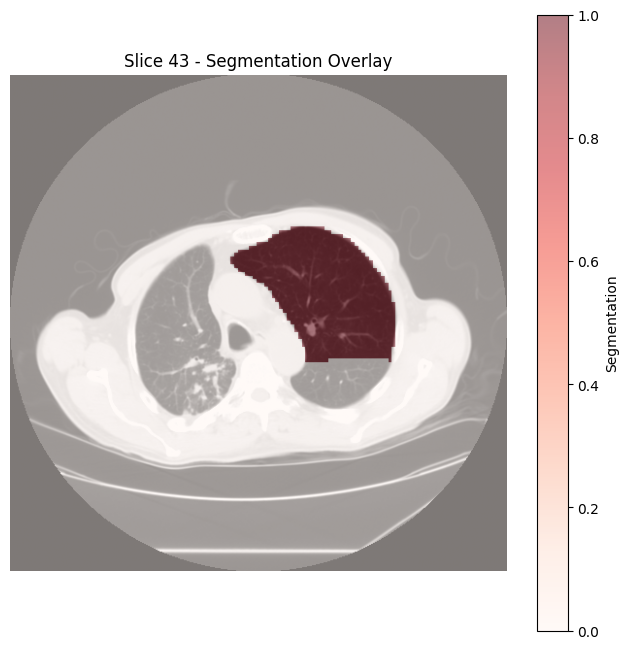

In [ ]:
# Visualize segmentation overlay
def show_overlay(volume, mask, slice_index=None, alpha=0.5):
    """Show CT scan with segmentation overlay"""
    if slice_index is None:
        slice_index = volume.shape[0] // 2

    plt.figure(figsize=(8, 8))
    plt.imshow(window_image(volume[slice_index]), cmap="gray")

    if np.any(mask[slice_index] > 0):
        plt.imshow(mask[slice_index], cmap="Reds", alpha=alpha)
        plt.title(f"Slice {slice_index} - Segmentation Overlay")
    else:
        plt.title(f"Slice {slice_index} - No segmentation on this slice")

    plt.axis("off")
    plt.colorbar(label="Segmentation")
    plt.show()

# Find slice with maximum segmentation
slice_sums = np.sum(mask, axis=(1, 2))
best_slice = np.argmax(slice_sums)
print(f"Slice with most segmentation: {best_slice}\n")
show_overlay(volume, mask, best_slice)

In [ ]:
# Interactive overlay viewer
from ipywidgets import interact, IntSlider, FloatSlider

def scroll_overlay(index, alpha=0.5):
    show_overlay(volume, mask, index, alpha)

interact(scroll_overlay,
         index=IntSlider(min=0, max=volume.shape[0]-1, value=best_slice, description='Slice'),
         alpha=FloatSlider(min=0, max=1, step=0.1, value=0.5, description='Opacity'))

interactive(children=(IntSlider(value=43, description='Slice', max=63), FloatSlider(value=0.5, description='Op…

<function __main__.scroll_overlay(index, alpha=0.5)>

## Step 7: Extract Radiomic Features with PyRadiomics

In [ ]:
# ================================
# Install PyRadiomics FROM SOURCE (new pyproject.toml build system)
# ================================
!git clone https://github.com/Radiomics/pyradiomics.git /content/pyradiomics
%cd /content/pyradiomics

# Build & install using pip (this replaces setup.py)
!/content/py310env/bin/pip install .

fatal: destination path '/content/pyradiomics' already exists and is not an empty directory.
/content/pyradiomics
Processing /content/pyradiomics
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp310-cp310-linux_x86_64.whl size=121919 sha256=86b2e5f559e3e6a7d5aa2c275e5c2029a2be1b7bce6bf64d5e3717558596c645
  Stored in directory: /tmp/pip-ephem-wheel-cache-d3ixfxbq/wheels/47/c4/a2/e972af67a41fcb34f09e51ec6d4e135b13504ea2e70db50a0a
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13781 sha256=6d8b88d4eab668fe519130c39a216948f717f1236b9c573c0eb9a3e613e36682
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36

In [ ]:
# Extract radiomic features using Python 3.10 environment
radiomics_script = """
import SimpleITK as sitk
from radiomics import featureextractor
import json

print("Extracting radiomic features...")

# Initialize feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Load image and mask
image_path = "/content/ct_volume.nii.gz"
mask_path = "/content/ts_output/lung_tumor.nii.gz"

# Check if tumor mask exists, otherwise use lung lobe
import os
if not os.path.exists(mask_path):
    mask_path = "/content/ts_output/lung_upper_lobe_left.nii.gz"
    print(f"Using {mask_path} instead of tumor mask")

# Extract features
features = extractor.execute(image_path, mask_path)

# Filter out metadata, keep only feature values
feature_dict = {}
for key, val in features.items():
    if not key.startswith('diagnostics_'):
        feature_dict[key] = float(val) if hasattr(val, '__float__') else str(val)

# Save to JSON
with open('/content/radiomic_features.json', 'w') as f:
    json.dump(feature_dict, f, indent=2)

print(f"\n✓ Extracted {len(feature_dict)} radiomic features")
print("\nSample features:")
for i, (k, v) in enumerate(list(feature_dict.items())[:5]):
    print(f"  {k}: {v}")
"""

"""with open('/content/extract_radiomics.py', 'w') as f:
    f.write(radiomics_script)"""
!/content/py310env/bin/python /content/extract_radiomics.py

Extracting radiomic features...
Using /content/ts_output/lung_upper_lobe_left.nii.gz instead of tumor mask
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
✓ Extracted 107 radiomic features
Sample features:
  original_shape_Elongation: 0.5307284659776524
  original_shape_Flatness: 0.33698857653847464
  original_shape_LeastAxisLength: 74.33408970779597
  original_shape_MajorAxisLength: 220.58341107983847
  original_shape_Maximum2DDiameterColumn: 194.7008547787156


In [ ]:
# Load and display radiomic features
import json
import pandas as pd

with open('/content/radiomic_features.json', 'r') as f:
    features = json.load(f)

# Convert to DataFrame for better visualization
df = pd.DataFrame(list(features.items()), columns=['Feature', 'Value'])

print(f"Total features extracted: {len(df)}\n")
print("Feature categories:")
categories = df['Feature'].str.split('_').str[0].value_counts()
print(categories)

print("\nFirst 10 features:")
print(df.head(10).to_string(index=False))

Total features extracted: 107

Feature categories:
Feature
original    107
Name: count, dtype: int64

First 10 features:
                               Feature        Value
             original_shape_Elongation 5.307285e-01
               original_shape_Flatness 3.369886e-01
        original_shape_LeastAxisLength 7.433409e+01
        original_shape_MajorAxisLength 2.205834e+02
original_shape_Maximum2DDiameterColumn 1.947009e+02
   original_shape_Maximum2DDiameterRow 2.375019e+02
 original_shape_Maximum2DDiameterSlice 1.579980e+02
      original_shape_Maximum3DDiameter 2.685440e+02
             original_shape_MeshVolume 1.211481e+06
        original_shape_MinorAxisLength 1.170699e+02


## Summary

This notebook demonstrated:
1. ✓ Setting up Python 3.10 virtual environment in Colab
2. ✓ Loading DICOM files from TCGA-LUSC dataset
3. ✓ Building 3D volumes with proper spacing
4. ✓ Visualizing CT scans with windowing
5. ✓ Running TotalSegmentator for automatic segmentation
6. ✓ Visualizing segmentation results
7. ✓ Extracting radiomic features with PyRadiomics

**Note**: All processing that requires PyRadiomics or specific Python versions is handled through the Python 3.10 virtual environment, while visualization and basic operations use the default Colab environment.

In [ ]:
import os

base_folder = "/content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC"

patients = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]

print("Number of patient folders:", len(patients))
print("\nFirst 10 patient IDs:")
print(patients[:10])

Number of patient folders: 37

First 10 patient IDs:
['TCGA-60-2716', 'TCGA-60-2711', 'TCGA-34-5928', 'TCGA-60-2710', 'TCGA-34-5236', 'TCGA-34-8455', 'TCGA-34-5239', 'TCGA-60-2696', 'TCGA-34-5231', 'TCGA-34-8454']


In [ ]:
import os

base_folder = "/content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC"

def find_dicom_series(patient_path):
    """Return the deepest folder that contains DICOM files."""
    for root, dirs, files in os.walk(patient_path):
        dcm_files = [f for f in files if f.lower().endswith(".dcm")]
        if len(dcm_files) > 5:  # found a CT series
            return root
    return None

patient_ct_paths = {}

for patient in os.listdir(base_folder):
    p_path = os.path.join(base_folder, patient)
    if os.path.isdir(p_path):
        series_path = find_dicom_series(p_path)
        patient_ct_paths[patient] = series_path

# Show summary
valid = {p: path for p, path in patient_ct_paths.items() if path is not None}

print("Patients with usable CT series:", len(valid))
print("\nExample paths:")
for k in list(valid.keys())[:5]:
    print(k, "→", valid[k])


Patients with usable CT series: 17

Example paths:
TCGA-60-2716 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2716/07-01-1996-NA-CT ANGIOGRAPHY CHEST WWO CON-22142/6.000000-HELICAL MODE-98985
TCGA-60-2711 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2711/02-24-1997-NA-PET CT SKULL BASE TO MID-THIGH-62169/3.000000-HELICAL MODE-22467
TCGA-34-5928 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-5928/07-27-1993-NA-CT THORAX  WITH CONTRA-33259/3.000000-Recon 2 BREAST SHIELDS PLEASE-71755
TCGA-60-2710 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2710/04-11-1995-NA-CT CHEST ABD W CONTRAST-25688/2.000000-HELICAL MODE-76149
TCGA-34-5236 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-5236/12-02-1990-NA-CHEST WO-07372/3.000000-Recon 2 HEILICAL-35696


In [ ]:
# Helper Function
load_code = """import os
import pydicom

BASE = "/content/drive/MyDrive/nd"
root_patients = []

# ---------- Step 1: Find the TCGA-LUSC folder automatically ----------
for root, dirs, files in os.walk(BASE):
    for d in dirs:
        if d == "TCGA-LUSC":
            LUSC_PATH = os.path.join(root, d)
            print("Found TCGA-LUSC at:", LUSC_PATH)
            root_patients.append(LUSC_PATH)

if len(root_patients) == 0:
    raise ValueError("TCGA-LUSC folder not found!")

LUSC_PATH = root_patients[0]   # use first match


# ---------- Step 2: Function to check if folder is a CT series ----------
def is_ct_series(folder):
    dicom_files = [f for f in os.listdir(folder) if f.lower().endswith(".dcm")]

    # Must have enough slices
    if len(dicom_files) < 30:
        return False

    try:
        sample = pydicom.dcmread(os.path.join(folder, dicom_files[0]), stop_before_pixels=True)
    except:
        return False

    # Must be CT
    if "CT" not in str(sample.Modality).upper():
        return False

    # Must have slice position metadata
    try:
        _ = float(sample.ImagePositionPatient[2])
    except:
        return False

    return True


# ---------- Step 3: Scan all patients and detect CT series ----------
patients = {}

for patient_id in os.listdir(LUSC_PATH):
    p_path = os.path.join(LUSC_PATH, patient_id)
    if not os.path.isdir(p_path):
        continue

    best_series = None
    best_slice_count = 0

    # go inside date folders
    for date_folder in os.listdir(p_path):
        date_path = os.path.join(p_path, date_folder)
        if not os.path.isdir(date_path):
            continue

        # go inside series folders
        for series_folder in os.listdir(date_path):
            s_path = os.path.join(date_path, series_folder)
            if not os.path.isdir(s_path):
                continue

            dicom_files = [f for f in os.listdir(s_path) if f.endswith(".dcm")]

            if len(dicom_files) < 20:
                continue

            # check if CT
            try:
                ds = pydicom.dcmread(os.path.join(s_path, dicom_files[0]), stop_before_pixels=True)
            except:
                continue

            if ds.Modality != "CT":
                continue

            # the more slices the better
            if len(dicom_files) > best_slice_count:
                best_slice_count = len(dicom_files)
                best_series = s_path

    if best_series:
        patients[patient_id] = best_series
        print(f"✓ {patient_id} → {best_series}  (slices={best_slice_count})")

print("\n--- FINAL RESULT ---")
print("Patients with valid CT:", len(patients))
patients"""

"""with open('/content/load_code.py', 'w') as f:
    f.write(load_code)"""
!/content/py310env/bin/python /content/load_code.py

Found TCGA-LUSC at: /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC
✓ TCGA-60-2716 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2716/07-01-1996-NA-CT ANGIOGRAPHY CHEST WWO CON-22142/7.000000-HELICAL MODE-00338  (slices=126)
✓ TCGA-60-2711 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2711/02-24-1997-NA-PET CT SKULL BASE TO MID-THIGH-62169/3.000000-HELICAL MODE-22467  (slices=312)
✓ TCGA-34-5928 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-5928/07-27-1993-NA-CT THORAX  WITH CONTRA-33259/2.000000-BREAST SHIELDS PLEASE-28830  (slices=432)
✓ TCGA-60-2710 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2710/04-11-1995-NA-CT CHEST ABD W CONTRAST-25688/2.000000-HELICAL MODE-76149  (slices=91)
✓ TCGA-34-5236 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-5236/12-10-1990-NA-CHEST-07235/5.0

In [ ]:
load_code2 = """import os
import pydicom

BASE = "/content/drive/MyDrive/nd"
root_patients = []

# ---------- Step 1: Find the TCGA-LUSC folder automatically ----------
for root, dirs, files in os.walk(BASE):
    for d in dirs:
        if d == "TCGA-LUSC":
            LUSC_PATH = os.path.join(root, d)
            print("Found TCGA-LUSC at:", LUSC_PATH)
            root_patients.append(LUSC_PATH)

if len(root_patients) == 0:
    raise ValueError("TCGA-LUSC folder not found!")

LUSC_PATH = root_patients[0]   # use first match


# ---------- Step 2: Function to check if folder is a CT series ----------
def is_ct_series(folder):
    dicom_files = [f for f in os.listdir(folder) if f.lower().endswith(".dcm")]

    # Must have enough slices
    if len(dicom_files) < 30:
        return False

    try:
        sample = pydicom.dcmread(os.path.join(folder, dicom_files[0]), stop_before_pixels=True)
    except:
        return False

    # Must be CT
    if "CT" not in str(sample.Modality).upper():
        return False

    # Must have slice position metadata
    try:
        _ = float(sample.ImagePositionPatient[2])
    except:
        return False

    return True


# ---------- Step 3: Scan all patients and detect CT series ----------
patients = {}

for patient_id in os.listdir(LUSC_PATH):
    p_path = os.path.join(LUSC_PATH, patient_id)
    if not os.path.isdir(p_path):
        continue

    best_series = None
    best_slice_count = 0

    # go inside date folders
    for date_folder in os.listdir(p_path):
        date_path = os.path.join(p_path, date_folder)
        if not os.path.isdir(date_path):
            continue

        # go inside series folders
        for series_folder in os.listdir(date_path):
            s_path = os.path.join(date_path, series_folder)
            if not os.path.isdir(s_path):
                continue

            dicom_files = [f for f in os.listdir(s_path) if f.endswith(".dcm")]

            if len(dicom_files) < 20:
                continue

            # check if CT
            try:
                ds = pydicom.dcmread(os.path.join(s_path, dicom_files[0]), stop_before_pixels=True)
            except:
                continue

            if ds.Modality != "CT":
                continue

            # the more slices the better
            if len(dicom_files) > best_slice_count:
                best_slice_count = len(dicom_files)
                best_series = s_path

    if best_series:
        patients[patient_id] = best_series
        print(f"✓ {patient_id} → {best_series}  (slices={best_slice_count})")

print("\n--- FINAL RESULT ---")
print("Patients with valid CT:", len(patients))
import os
import pydicom
import numpy as np
import SimpleITK as sitk

# patients dict is already created
print("Patients detected:", len(patients))
os.makedirs("/content/ct_volumes", exist_ok=True)

def load_dicom_series(folder):
    files = sorted([os.path.join(folder,f) for f in os.listdir(folder) if f.endswith(".dcm")])

    slices = []
    for f in files:
        try:
            ds = pydicom.dcmread(f)
            slices.append(ds)
        except:
            continue

    # Sort by slice position
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    # Build volume
    volume = np.stack([s.pixel_array for s in slices]).astype(np.int16)

    # Convert to HU
    for i, ds in enumerate(slices):
        intercept = getattr(ds, "RescaleIntercept", 0)
        slope = getattr(ds, "RescaleSlope", 1)
        volume[i] = volume[i] * slope + intercept

    # Convert to SimpleITK image
    itk_img = sitk.GetImageFromArray(volume)

    # Set spacing from DICOM metadata
    px_spacing = list(map(float, slices[0].PixelSpacing))
    slice_thickness = abs(float(slices[1].ImagePositionPatient[2]) - float(slices[0].ImagePositionPatient[2]))
    spacing = [slice_thickness] + px_spacing  # (z, y, x)

    itk_img.SetSpacing(spacing)

    return itk_img


# ---------------------------
# Process all patients
# ---------------------------
for pid, path in patients.items():
    print(f"\nProcessing {pid} ...")

    img = load_dicom_series(path)
    out_path = f"/content/ct_volumes/{pid}.nii.gz"

    sitk.WriteImage(img, out_path)
    print(f"✓ Saved: {out_path}")

print("\nAll CT volumes saved!")
"""

"""with open('/content/load_code2.py', 'w') as f:
    f.write(load_code2)"""
!/content/py310env/bin/python /content/load_code2.py

Found TCGA-LUSC at: /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC
✓ TCGA-60-2716 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2716/07-01-1996-NA-CT ANGIOGRAPHY CHEST WWO CON-22142/7.000000-HELICAL MODE-00338  (slices=126)
✓ TCGA-60-2711 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2711/02-24-1997-NA-PET CT SKULL BASE TO MID-THIGH-62169/3.000000-HELICAL MODE-22467  (slices=312)
✓ TCGA-34-5928 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-5928/07-27-1993-NA-CT THORAX  WITH CONTRA-33259/2.000000-BREAST SHIELDS PLEASE-28830  (slices=432)
✓ TCGA-60-2710 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-60-2710/04-11-1995-NA-CT CHEST ABD W CONTRAST-25688/2.000000-HELICAL MODE-76149  (slices=91)
✓ TCGA-34-5236 → /content/drive/MyDrive/nd/manifest-27oBhciT6753657225075401932/TCGA-LUSC/TCGA-34-5236/12-10-1990-NA-CHEST-07235/5.0

In [ ]:
import os
import subprocess
import time
import torch

# Configuration
input_folder = "/content/ct_volumes"
output_folder = "/content/ts_output"
os.makedirs(output_folder, exist_ok=True)

# Get all files
nii_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".nii.gz")])

# Print all file names for reference
print("="*60)
print("ALL FILES TO PROCESS:")
print("="*60)
for i, f in enumerate(nii_files, 1):
    size_mb = os.path.getsize(os.path.join(input_folder, f)) / (1024*1024)
    print(f"{i:2d}. {f:<30s} ({size_mb:6.1f} MB)")
print("="*60)
print(f"\nTotal: {len(nii_files)} files\n")

# ============================================================
# CHANGE THIS NUMBER TO PROCESS DIFFERENT FILES (1-17)
# ============================================================
FILE_INDEX = 5  # ← CHANGE THIS NUMBER (1 to 17)
# ============================================================

if FILE_INDEX < 1 or FILE_INDEX > len(nii_files):
    print(f"❌ ERROR: FILE_INDEX must be between 1 and {len(nii_files)}")
else:
    # Get the file to process
    f = nii_files[FILE_INDEX - 1]
    pid = f.replace(".nii.gz", "")
    in_path = os.path.join(input_folder, f)
    out_path = os.path.join(output_folder, pid)

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"\n{'='*60}")
    print(f"PROCESSING FILE {FILE_INDEX}/{len(nii_files)}: {pid}")
    print(f"{'='*60}")
    print(f"Input:  {in_path}")
    print(f"Output: {out_path}")
    print(f"Start time: {time.strftime('%H:%M:%S')}\n")

    # Get file size
    size_mb = os.path.getsize(in_path) / (1024*1024)
    print(f"Input file size: {size_mb:.2f} MB")

    # Check if already processed
    if os.path.exists(out_path) and os.listdir(out_path):
        print(f"\n⚠️ Output folder already exists with {len(os.listdir(out_path))} files")
        print("To re-process, delete the output folder first or skip this file")
    else:
        # Build command
        cmd = [
            "/content/py310env/bin/TotalSegmentator",
            "-i", in_path,
            "-o", out_path,
            "--fast",
            "--roi_subset",
            "lung_lower_lobe_left",
            "lung_lower_lobe_right",
            "lung_middle_lobe_right",
            "lung_upper_lobe_left",
            "lung_upper_lobe_right"
        ]

        print("\nSegmenting lung lobes only...")
        print(f"Command: {' '.join(cmd)}\n")

        # Run the command
        result = subprocess.run(cmd)

        print(f"\nEnd time: {time.strftime('%H:%M:%S')}")

        if result.returncode == 0:
            num_files = len([f for f in os.listdir(out_path) if f.endswith('.nii.gz')])
            print(f"\n✅ SUCCESS! Generated {num_files} segmentation files")
            print(f"Output location: {out_path}")
        else:
            print(f"\n❌ FAILED with return code: {result.returncode}")

    print("\n" + "="*60)
    print(f"To process next file, change FILE_INDEX to {FILE_INDEX + 1}")
    print("="*60)

ALL FILES TO PROCESS:
 1. TCGA-34-2605.nii.gz            (  12.7 MB)
 2. TCGA-34-5231.nii.gz            ( 140.7 MB)
 3. TCGA-34-5234.nii.gz            ( 138.9 MB)
 4. TCGA-34-5236.nii.gz            ( 153.1 MB)
 5. TCGA-34-5239.nii.gz            (  86.2 MB)
 6. TCGA-34-5240.nii.gz            (  91.7 MB)
 7. TCGA-34-5241.nii.gz            (  17.5 MB)
 8. TCGA-34-5928.nii.gz            ( 123.4 MB)
 9. TCGA-34-8454.nii.gz            ( 131.9 MB)
10. TCGA-34-8455.nii.gz            (  29.7 MB)
11. TCGA-51-4079.nii.gz            (  95.5 MB)
12. TCGA-60-2695.nii.gz            (  60.4 MB)
13. TCGA-60-2696.nii.gz            (  56.5 MB)
14. TCGA-60-2710.nii.gz            (  21.9 MB)
15. TCGA-60-2711.nii.gz            (  62.8 MB)
16. TCGA-60-2716.nii.gz            (  30.6 MB)
17. TCGA-60-2721.nii.gz            (  66.8 MB)

Total: 17 files


PROCESSING FILE 5/17: TCGA-34-5239
Input:  /content/ct_volumes/TCGA-34-5239.nii.gz
Output: /content/ts_output/TCGA-34-5239
Start time: 04:15:21

Input file size

In [ ]:
p = """import os
import SimpleITK as sitk
import numpy as np

ts_root = "/content/drive/MyDrive/dataset_lung/ts_output/F_dataset"
mask_out = "/content/lung_masks"
os.makedirs(mask_out, exist_ok=True)

lung_lobes = [
    "lung_upper_lobe_left.nii.gz",
    "lung_lower_lobe_left.nii.gz",
    "lung_upper_lobe_right.nii.gz",
    "lung_middle_lobe_right.nii.gz",
    "lung_lower_lobe_right.nii.gz"
]

patients = sorted(os.listdir(ts_root))

print(f"Processing {len(patients)} patients...\n")

for pid in patients:
    pid_folder = os.path.join(ts_root, pid)
    if not os.path.isdir(pid_folder):
        continue

    combined = None
    ref_img = None

    for lobe in lung_lobes:
        lobe_path = os.path.join(pid_folder, lobe)
        if not os.path.exists(lobe_path):
            continue

        img = sitk.ReadImage(lobe_path)
        arr = sitk.GetArrayFromImage(img)

        if combined is None:
            combined = arr.copy()
            ref_img = img
        else:
            combined += arr

    if combined is None:
        print(f"❌ No lung masks found for {pid}")
        continue

    combined = (combined > 0).astype(np.uint8)

    out_img = sitk.GetImageFromArray(combined)
    out_img.CopyInformation(ref_img)

    out_path = os.path.join(mask_out, f"{pid}_lungmask.nii.gz")
    sitk.WriteImage(out_img, out_path)

    print(f"✓ Saved lung mask: {pid}")

print("\n🎉 Lung mask generation completed!")"""

"""with open('/content/load_retrieved_data.py', 'w') as f:
    f.write(p)"""
!/content/py310env/bin/python /content/load_retrieved_data.py

Processing 9 patients...
✓ Saved lung mask: TCGA-34-2605
✓ Saved lung mask: TCGA-34-5241
✓ Saved lung mask: TCGA-34-8455
✓ Saved lung mask: TCGA-60-2695
✓ Saved lung mask: TCGA-60-2696
✓ Saved lung mask: TCGA-60-2710
✓ Saved lung mask: TCGA-60-2711
✓ Saved lung mask: TCGA-60-2716
✓ Saved lung mask: TCGA-60-2721
🎉 Lung mask generation completed!


In [ ]:
!cp -r /content/lung_masks /content/drive/MyDrive/dataset_lung/

In [ ]:
fix = """import os
import SimpleITK as sitk
import numpy as np

ct_folder = "/content/ct_volumes"
mask_folder = "/content/lung_masks"
fixed_mask_folder = "/content/lung_masks_fixed"

os.makedirs(fixed_mask_folder, exist_ok=True)

mask_files = [f for f in os.listdir(mask_folder) if f.endswith("_lungmask.nii.gz")]

print(f"Fixing {len(mask_files)} lung masks...\n")

for mf in mask_files:
    pid = mf.replace("_lungmask.nii.gz", "")
    ct_path = os.path.join(ct_folder, f"{pid}.nii.gz")
    mask_path = os.path.join(mask_folder, mf)

    if not os.path.exists(ct_path):
        print(f"⚠️ CT missing for {pid}, skipping")
        continue

    # Load CT and mask
    ct_img = sitk.ReadImage(ct_path)
    mask_img = sitk.ReadImage(mask_path)

    mask_arr = sitk.GetArrayFromImage(mask_img)

    # Sanity check
    if np.sum(mask_arr) == 0:
        print(f"❌ Empty mask detected for {pid}, skipping")
        continue

    # Force binary label = 1
    mask_arr = (mask_arr > 0).astype(np.uint8)

    # Create new mask with CT metadata
    fixed_mask = sitk.GetImageFromArray(mask_arr)
    fixed_mask.CopyInformation(ct_img)

    out_path = os.path.join(fixed_mask_folder, f"{pid}_lungmask.nii.gz")
    sitk.WriteImage(fixed_mask, out_path)

    print(f"✓ Fixed mask saved: {pid}")

print("\n✅ All masks fixed and aligned")
"""
"""with open('/content/radiomics_fix_data.py', 'w') as f:
    f.write(fix)"""
!/content/py310env/bin/python /content/radiomics_fix_data.py

Fixing 9 lung masks...
✓ Fixed mask saved: TCGA-60-2696
✓ Fixed mask saved: TCGA-60-2721
✓ Fixed mask saved: TCGA-60-2716
❌ Empty mask detected for TCGA-34-2605, skipping
✓ Fixed mask saved: TCGA-60-2710
✓ Fixed mask saved: TCGA-34-8455
✓ Fixed mask saved: TCGA-34-5241
✓ Fixed mask saved: TCGA-60-2695
✓ Fixed mask saved: TCGA-60-2711
✅ All masks fixed and aligned


In [ ]:
n = """import os
import pandas as pd
from radiomics import featureextractor

ct_folder = "/content/ct_volumes"
mask_folder = "/content/lung_masks_fixed"

extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()

extractor.enableFeatureClassByName("firstorder")
extractor.enableFeatureClassByName("shape")
extractor.enableFeatureClassByName("glcm")
extractor.enableFeatureClassByName("glrlm")
extractor.enableFeatureClassByName("glszm")

results = []

mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith("_lungmask.nii.gz")])

print(f"Extracting radiomics for {len(mask_files)} patients...\n")

for mf in mask_files:
    pid = mf.replace("_lungmask.nii.gz", "")
    ct_path = os.path.join(ct_folder, f"{pid}.nii.gz")
    mask_path = os.path.join(mask_folder, mf)

    if not os.path.exists(ct_path):
        print(f"⚠️ CT missing for {pid}, skipping")
        continue

    print(f"→ {pid}")

    features = extractor.execute(ct_path, mask_path)

    row = {"PatientID": pid}
    for k, v in features.items():
        if isinstance(v, (int, float)):
            row[k] = v

    results.append(row)

df = pd.DataFrame(results)
csv_path = "/content/lung_radiomics_features.csv"
df.to_csv(csv_path, index=False)

print(f"\n✅ Radiomics saved to: {csv_path}")"""

"""with open('/content/radiomics_new_data.py', 'w') as f:
    f.write(n)"""
!/content/py310env/bin/python /content/radiomics_new_data.py

Extracting radiomics for 8 patients...
→ TCGA-34-5241
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-34-8455
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-60-2695
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-60-2696
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-60-2710
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-60-2711
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-60-2716
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
→ TCGA-60-2721
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
✅ Radiomics saved to: /content/lung_radiomics_features.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_features.csv")

print("Patients:", df.shape[0])
print("Features:", df.shape[1] - 1)
df.head()

Patients: 8
Features: 11


,PatientID,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_MinorAxisLength,original_shape_VoxelVolume
0,TCGA-34-5241,-713.563190,-2048.0,3071.0,20753,8,0.036758,0.018057,22.249260,1232.182676,45.292085,4.336771e+04
1,TCGA-34-8455,-825.957118,-2048.0,3071.0,253323,16,0.385019,0.114931,47.737784,415.358676,159.921173,4.529501e+05
2,TCGA-60-2695,-1106.949712,-3024.0,3071.0,786710,8,0.187933,0.055995,50.163788,895.863633,168.362759,2.453365e+06
3,TCGA-60-2696,-1224.495009,-3024.0,3071.0,647581,5,0.175515,0.067332,55.163865,819.282436,143.796265,2.019489e+06
4,TCGA-60-2710,-840.007056,-3024.0,3071.0,187488,19,0.082110,0.015289,26.372666,1724.892845,141.630729,4.380664e+05


**Clean & Normalize Radiomics Features**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_features.csv")
print(df.columns.tolist())

['PatientID', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_MinorAxisLength', 'original_shape_VoxelVolume']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --------------------------------
# Load data
# --------------------------------
df = pd.read_csv("/content/lung_radiomics_features.csv")
print("Original shape:", df.shape)

# --------------------------------
# Separate PatientID
# --------------------------------
patient_ids = df["PatientID"]
df = df.drop(columns=["PatientID"])

# --------------------------------
# Remove diagnostics (not radiomics)
# --------------------------------
df = df.loc[:, ~df.columns.str.startswith("diagnostics")]

print("After removing diagnostics:", df.shape)

# --------------------------------
# Remove zero-variance features
# --------------------------------
variance = df.var()
df = df.loc[:, variance > 1e-6]

# --------------------------------
# Handle NaN / Inf
# --------------------------------
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(df.mean())

# --------------------------------
# Z-score normalization
# --------------------------------
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled.insert(0, "PatientID", patient_ids.values)

# --------------------------------
# Save cleaned dataset
# --------------------------------
out_path = "/content/lung_radiomics_clean.csv"
df_scaled.to_csv(out_path, index=False)

print("✅ Clean radiomics saved to:", out_path)
print("Final shape:", df_scaled.shape)


Original shape: (8, 12)
After removing diagnostics: (8, 6)
✅ Clean radiomics saved to: /content/lung_radiomics_clean.csv
Final shape: (8, 7)


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/lung_radiomics_clean.csv")

# --------------------------------
# Novel composite features
# --------------------------------
df["Shape_Complexity"] = (
    df["original_shape_MajorAxisLength"] /
    (df["original_shape_MinorAxisLength"] + 1e-6)
)

df["Elongation_Flatness_Ratio"] = (
    df["original_shape_Elongation"] /
    (df["original_shape_Flatness"] + 1e-6)
)

df["Normalized_Lung_Size"] = (
    df["original_shape_VoxelVolume"] /
    df["original_shape_MajorAxisLength"]
)

df["Axis_Disparity"] = (
    df["original_shape_MajorAxisLength"] -
    df["original_shape_LeastAxisLength"]
)

# Save novel features
out_path = "/content/lung_radiomics_novel.csv"
df.to_csv(out_path, index=False)

print("🔥 Novel radiomic biomarkers created!")
print("Saved to:", out_path)
print("Final shape:", df.shape)

🔥 Novel radiomic biomarkers created!
Saved to: /content/lung_radiomics_novel.csv
Final shape: (8, 11)


**PCA + visualization**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv("/content/lung_radiomics_novel.csv")

patient_ids = df["PatientID"]
X = df.drop(columns=["PatientID"])

print("Data shape:", X.shape)

Data shape: (8, 10)


In [ ]:
# -------------------------------
# PCA
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["PatientID"] = patient_ids.values

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.63465834 0.2209344 ]
Total variance explained: 0.8555927452946327


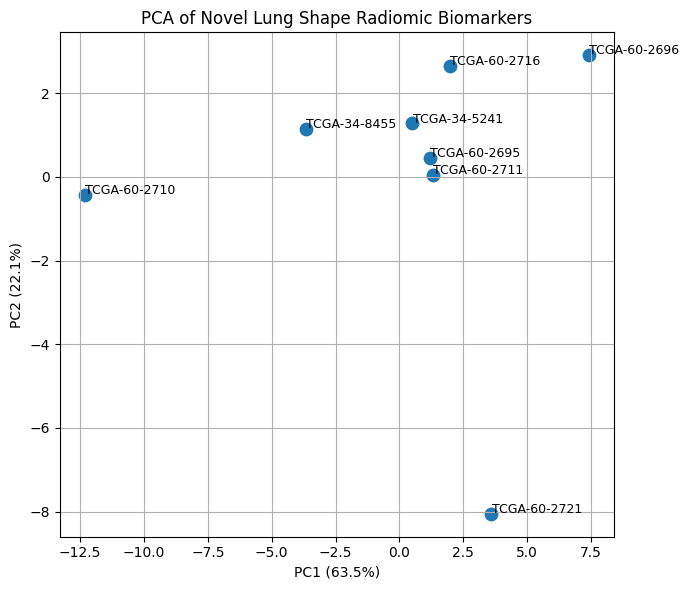

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=80)

for i, pid in enumerate(pca_df["PatientID"]):
    plt.text(
        pca_df["PC1"][i] + 0.02,
        pca_df["PC2"][i] + 0.02,
        pid,
        fontsize=9
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Novel Lung Shape Radiomic Biomarkers")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=X.columns
)

print(loadings.sort_values("PC1", ascending=False))

                                     PC1       PC2
Shape_Complexity                0.946021  0.225933
original_shape_LeastAxisLength  0.114328 -0.136612
original_shape_VoxelVolume      0.103463 -0.208274
original_shape_Flatness         0.050077 -0.034996
original_shape_MinorAxisLength  0.019682 -0.117446
original_shape_Elongation       0.015347 -0.023300
Elongation_Flatness_Ratio      -0.018647  0.006535
original_shape_MajorAxisLength -0.094378 -0.012182
Normalized_Lung_Size           -0.159138  0.925029
Axis_Disparity                 -0.208706  0.124430


**Novelty**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/lung_radiomics_novel.csv")

In [ ]:
df["axis_ratio"] = (
    df["original_shape_MajorAxisLength"] /
    df["original_shape_MinorAxisLength"]
)

df["shape_complexity_index"] = (
    df["original_shape_Elongation"] *
    df["original_shape_Flatness"] *
    df["axis_ratio"]
)

In [ ]:
print(df[["PatientID", "shape_complexity_index"]])

      PatientID  shape_complexity_index
0  TCGA-34-5241               -0.411563
1  TCGA-34-8455              -26.491776
2  TCGA-60-2695               -0.007272
3  TCGA-60-2696                0.069806
4  TCGA-60-2710              -16.236807
5  TCGA-60-2711               -0.000779
6  TCGA-60-2716                0.127865
7  TCGA-60-2721               -0.030378


In [ ]:
df.to_csv("/content/lung_radiomics_novel.csv", index=False)
print("✅ shape_complexity_index added and saved")

✅ shape_complexity_index added and saved


In [ ]:
median_value = df["shape_complexity_index"].median()

df["Complexity_Group"] = np.where(
    df["shape_complexity_index"] >= median_value,
    "High_Complexity",
    "Low_Complexity"
)

print(df[["PatientID", "shape_complexity_index", "Complexity_Group"]])
print("\nGroup counts:")
print(df["Complexity_Group"].value_counts())

      PatientID  shape_complexity_index Complexity_Group
0  TCGA-34-5241               -0.411563   Low_Complexity
1  TCGA-34-8455              -26.491776   Low_Complexity
2  TCGA-60-2695               -0.007272  High_Complexity
3  TCGA-60-2696                0.069806  High_Complexity
4  TCGA-60-2710              -16.236807   Low_Complexity
5  TCGA-60-2711               -0.000779  High_Complexity
6  TCGA-60-2716                0.127865  High_Complexity
7  TCGA-60-2721               -0.030378   Low_Complexity

Group counts:
Complexity_Group
Low_Complexity     4
High_Complexity    4
Name: count, dtype: int64


In [ ]:
from scipy.stats import mannwhitneyu

features_to_test = [
    "original_shape_MajorAxisLength",
    "original_shape_MinorAxisLength",
    "original_shape_Elongation",
    "original_shape_Flatness",
    "original_shape_VoxelVolume"
]

results = []

for feat in features_to_test:
    group_high = df[df["Complexity_Group"] == "High_Complexity"][feat]
    group_low  = df[df["Complexity_Group"] == "Low_Complexity"][feat]

    stat, p = mannwhitneyu(group_high, group_low, alternative="two-sided")

    results.append([feat, p])

stats_df = pd.DataFrame(results, columns=["Feature", "p_value"])
print(stats_df)

                          Feature   p_value
0  original_shape_MajorAxisLength  0.685714
1  original_shape_MinorAxisLength  0.485714
2       original_shape_Elongation  1.000000
3         original_shape_Flatness  1.000000
4      original_shape_VoxelVolume  0.342857


<Figure size 600x500 with 0 Axes>

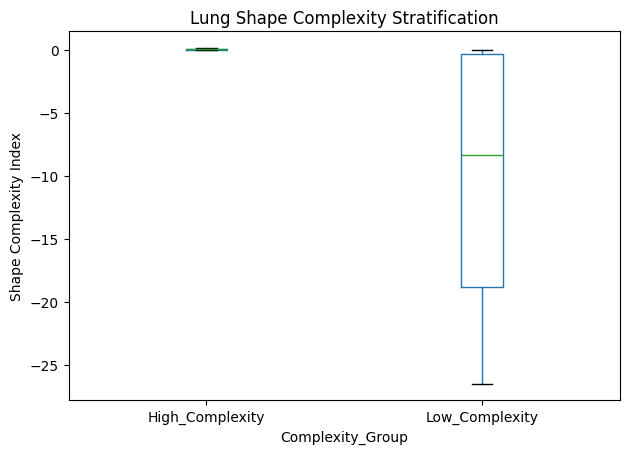

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

df.boxplot(
    column="shape_complexity_index",
    by="Complexity_Group",
    grid=False
)

plt.title("Lung Shape Complexity Stratification")
plt.suptitle("")
plt.ylabel("Shape Complexity Index")
plt.tight_layout()
plt.show()

**Unsupervised clustering (phenotypes)**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_novel.csv")
print(df.shape)
df.head()

(8, 13)


,PatientID,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_MinorAxisLength,original_shape_VoxelVolume,Shape_Complexity,Elongation_Flatness_Ratio,Normalized_Lung_Size,Axis_Disparity,axis_ratio,shape_complexity_index
0,TCGA-34-5241,-1.419024,-1.201635,-1.706891,0.596442,-2.471125,-1.263555,-0.241365,1.180912,-2.118488,2.303333,-0.241365,-0.411563
1,TCGA-34-8455,2.210286,2.031999,0.170861,-1.713881,0.290564,-0.967643,-5.898445,1.087739,0.564592,-1.884743,-5.898465,-26.491776
2,TCGA-60-2695,0.156412,0.064722,0.349586,-0.354810,0.493942,0.477601,-0.718322,2.416628,-1.346073,-0.704396,-0.718324,-0.007272
3,TCGA-60-2696,0.026995,0.443147,0.717944,-0.571414,-0.097924,0.164138,5.835361,0.060916,-0.287248,-1.289358,5.835302,0.069806
4,TCGA-60-2710,-0.946398,-1.294008,-1.403118,1.990035,-0.150097,-0.978397,-13.258445,0.731371,-0.491648,3.393152,-13.258356,-16.236807


In [ ]:
features = [
    "original_shape_Elongation",
    "original_shape_Flatness",
    "original_shape_MajorAxisLength",
    "original_shape_MinorAxisLength",
    "original_shape_LeastAxisLength",
    "shape_complexity_index"
]

X = df[features]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

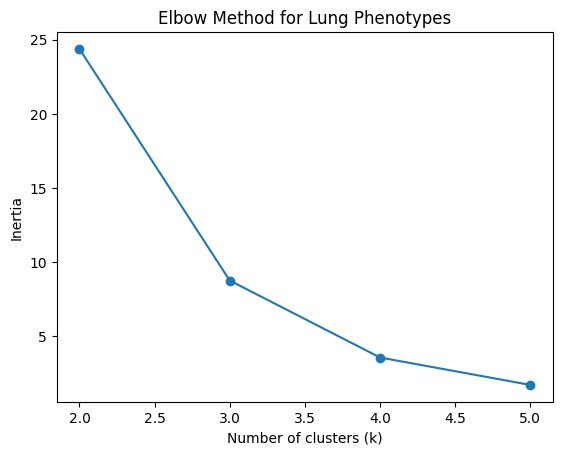

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 6)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Lung Phenotypes")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["phenotype"] = kmeans.fit_predict(X_scaled)

In [ ]:
print(df[["PatientID", "shape_complexity_index", "phenotype"]])

      PatientID  shape_complexity_index  phenotype
0  TCGA-34-5241               -0.411563          1
1  TCGA-34-8455              -26.491776          0
2  TCGA-60-2695               -0.007272          0
3  TCGA-60-2696                0.069806          0
4  TCGA-60-2710              -16.236807          1
5  TCGA-60-2711               -0.000779          0
6  TCGA-60-2716                0.127865          0
7  TCGA-60-2721               -0.030378          0


In [ ]:
summary = df.groupby("phenotype")[features].mean()
print(summary)

           original_shape_Elongation  original_shape_Flatness  \
phenotype                                                       
0                           0.394237                 0.415941   
1                          -1.182711                -1.247822   

           original_shape_MajorAxisLength  original_shape_MinorAxisLength  \
phenotype                                                                   
0                               -0.431079                        0.436870   
1                                1.293238                       -1.310611   

           original_shape_LeastAxisLength  shape_complexity_index  
phenotype                                                          
0                                0.518335               -4.388756  
1                               -1.555004               -8.324185  


**Visualization of lung phenotypes**

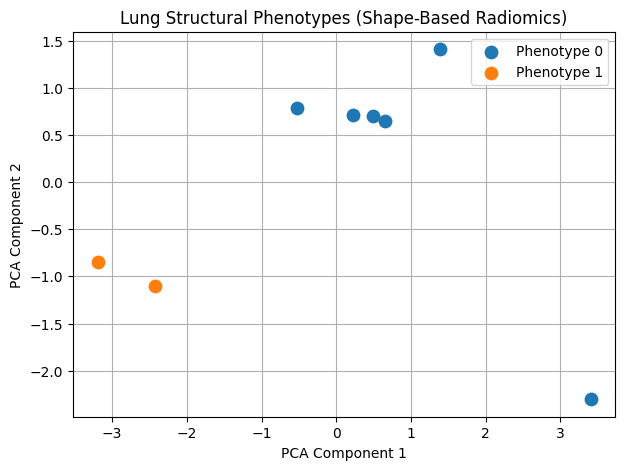

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(7,5))
for phenotype in sorted(df["phenotype"].unique()):
    subset = df["phenotype"] == phenotype
    plt.scatter(
        X_pca[subset, 0],
        X_pca[subset, 1],
        label=f"Phenotype {phenotype}",
        s=80
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Lung Structural Phenotypes (Shape-Based Radiomics)")
plt.legend()
plt.grid(True)
plt.show()

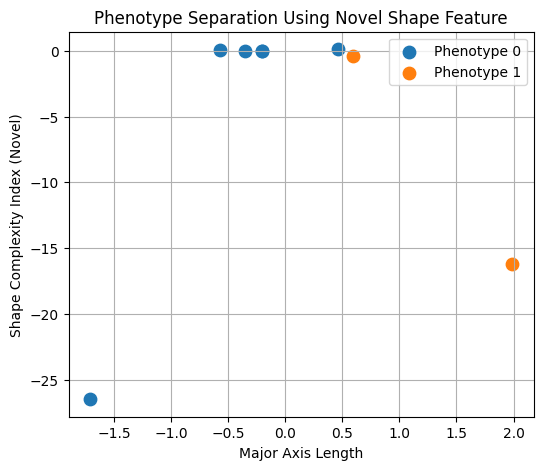

In [ ]:
plt.figure(figsize=(6,5))

for phenotype in sorted(df["phenotype"].unique()):
    subset = df["phenotype"] == phenotype
    plt.scatter(
        df.loc[subset, "original_shape_MajorAxisLength"],
        df.loc[subset, "shape_complexity_index"],
        label=f"Phenotype {phenotype}",
        s=80
    )

plt.xlabel("Major Axis Length")
plt.ylabel("Shape Complexity Index (Novel)")
plt.title("Phenotype Separation Using Novel Shape Feature")
plt.legend()
plt.grid(True)
plt.show()

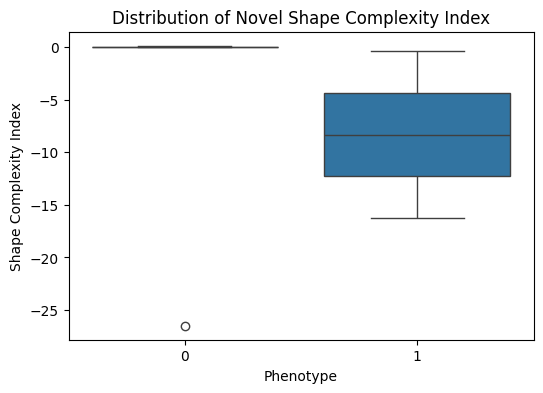

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(
    x="phenotype",
    y="shape_complexity_index",
    data=df
)

plt.xlabel("Phenotype")
plt.ylabel("Shape Complexity Index")
plt.title("Distribution of Novel Shape Complexity Index")
plt.show()

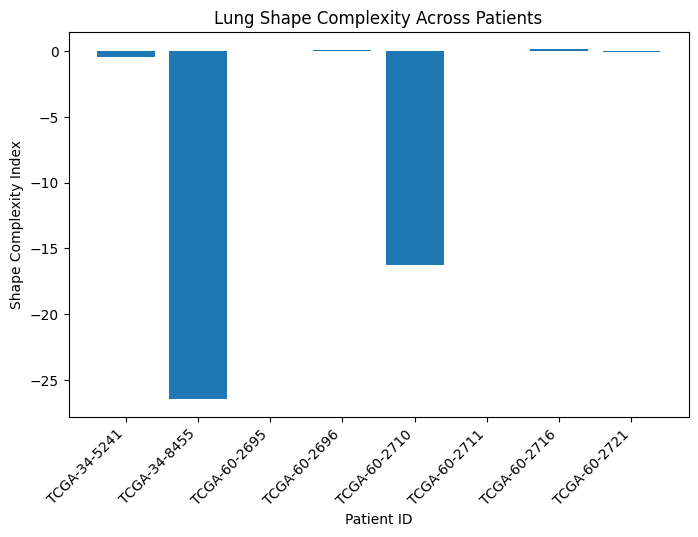

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_novel.csv")

plt.figure(figsize=(8, 5))
plt.bar(df["PatientID"], df["shape_complexity_index"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Patient ID")
plt.ylabel("Shape Complexity Index")
plt.title("Lung Shape Complexity Across Patients")

# 🔹 STEP D4: Save figure
plt.savefig("phenotype_shape_complexity.png",
            dpi=300,
            bbox_inches="tight")

plt.show()

**Statistical validation (effect size + p-values)bold text**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_novel.csv")
print(df.shape)
df.head()

(8, 13)


,PatientID,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_MinorAxisLength,original_shape_VoxelVolume,Shape_Complexity,Elongation_Flatness_Ratio,Normalized_Lung_Size,Axis_Disparity,axis_ratio,shape_complexity_index
0,TCGA-34-5241,-1.419024,-1.201635,-1.706891,0.596442,-2.471125,-1.263555,-0.241365,1.180912,-2.118488,2.303333,-0.241365,-0.411563
1,TCGA-34-8455,2.210286,2.031999,0.170861,-1.713881,0.290564,-0.967643,-5.898445,1.087739,0.564592,-1.884743,-5.898465,-26.491776
2,TCGA-60-2695,0.156412,0.064722,0.349586,-0.354810,0.493942,0.477601,-0.718322,2.416628,-1.346073,-0.704396,-0.718324,-0.007272
3,TCGA-60-2696,0.026995,0.443147,0.717944,-0.571414,-0.097924,0.164138,5.835361,0.060916,-0.287248,-1.289358,5.835302,0.069806
4,TCGA-60-2710,-0.946398,-1.294008,-1.403118,1.990035,-0.150097,-0.978397,-13.258445,0.731371,-0.491648,3.393152,-13.258356,-16.236807


In [ ]:
#Create two groups using your novel feature

feature = "shape_complexity_index"

median_val = df[feature].median()

group_low  = df[df[feature] <= median_val][feature]
group_high = df[df[feature] >  median_val][feature]

print("Low group size :", len(group_low))
print("High group size:", len(group_high))

Low group size : 4
High group size: 4


In [ ]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_std

d_value = cohens_d(group_high, group_low)
print("Cohen's d:", d_value)

Cohen's d: 1.1878143482642434


In [ ]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(group_high, group_low, alternative="two-sided")

print("U statistic:", u_stat)
print("p-value:", p_value)

U statistic: 16.0
p-value: 0.02857142857142857


In [ ]:
results = pd.DataFrame({
    "Feature": [feature],
    "Cohens_d": [d_value],
    "p_value": [p_value],
    "Mean_low": [group_low.mean()],
    "Mean_high": [group_high.mean()]
})

results.to_csv("/content/statistical_validation_results.csv", index=False)
results

,Feature,Cohens_d,p_value,Mean_low,Mean_high
0,shape_complexity_index,1.187814,0.028571,-10.792631,0.047405


**Correlation analysis (prove non-redundancy)**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_novel.csv")

novel_feature = "shape_complexity_index"

# Select only numeric radiomics (exclude PatientID)
radiomics_features = df.drop(columns=["PatientID"])

print("Total features:", radiomics_features.shape[1])

Total features: 12


In [ ]:
corr = radiomics_features.corr(method="spearman")

novel_corr = corr[novel_feature].drop(novel_feature)

novel_corr.sort_values()

,shape_complexity_index
Elongation_Flatness_Ratio,-0.523810
original_shape_Elongation,-0.142857
original_shape_Flatness,-0.071429
original_shape_MajorAxisLength,-0.023810
Normalized_Lung_Size,0.047619
Axis_Disparity,0.071429
original_shape_LeastAxisLength,0.357143
original_shape_MinorAxisLength,0.428571
original_shape_VoxelVolume,0.452381
Shape_Complexity,0.761905


In [ ]:
high_corr = novel_corr[abs(novel_corr) > 0.7]

print("Highly correlated features (>0.7):")
high_corr

Highly correlated features (>0.7):


,shape_complexity_index
Shape_Complexity,0.761905
axis_ratio,0.761905


In [ ]:
mean_abs_corr = abs(novel_corr).mean()
max_abs_corr  = abs(novel_corr).max()

print("Mean |correlation| :", mean_abs_corr)
print("Max  |correlation| :", max_abs_corr)

Mean |correlation| : 0.33116883116883117
Max  |correlation| : 0.7619047619047619


In [ ]:
novel_corr.to_csv("/content/novel_feature_correlations.csv")

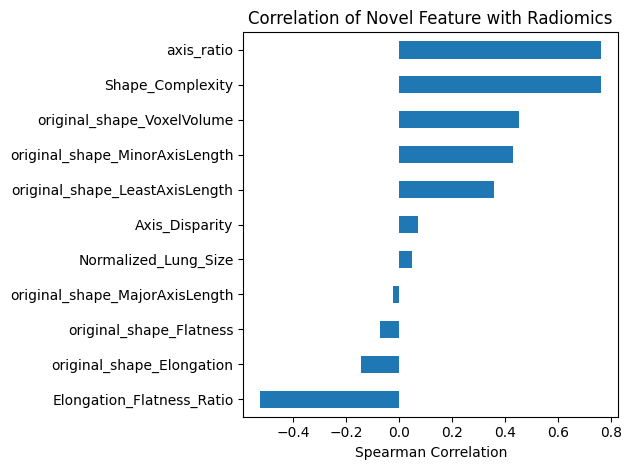

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
novel_corr.sort_values().plot(kind="barh")
plt.title("Correlation of Novel Feature with Radiomics")
plt.xlabel("Spearman Correlation")
plt.tight_layout()
plt.savefig("/content/novel_feature_correlation_plot.png")
plt.show()

**Machine Learning validation 🔥**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/lung_radiomics_novel.csv")

print(df.shape)
df.head()

(8, 13)


,PatientID,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_MinorAxisLength,original_shape_VoxelVolume,Shape_Complexity,Elongation_Flatness_Ratio,Normalized_Lung_Size,Axis_Disparity,axis_ratio,shape_complexity_index
0,TCGA-34-5241,-1.419024,-1.201635,-1.706891,0.596442,-2.471125,-1.263555,-0.241365,1.180912,-2.118488,2.303333,-0.241365,-0.411563
1,TCGA-34-8455,2.210286,2.031999,0.170861,-1.713881,0.290564,-0.967643,-5.898445,1.087739,0.564592,-1.884743,-5.898465,-26.491776
2,TCGA-60-2695,0.156412,0.064722,0.349586,-0.354810,0.493942,0.477601,-0.718322,2.416628,-1.346073,-0.704396,-0.718324,-0.007272
3,TCGA-60-2696,0.026995,0.443147,0.717944,-0.571414,-0.097924,0.164138,5.835361,0.060916,-0.287248,-1.289358,5.835302,0.069806
4,TCGA-60-2710,-0.946398,-1.294008,-1.403118,1.990035,-0.150097,-0.978397,-13.258445,0.731371,-0.491648,3.393152,-13.258356,-16.236807


In [ ]:
import numpy as np

# REMOVE this once real labels are available
np.random.seed(42)
df["label"] = np.random.randint(0, 2, size=len(df))

In [ ]:
from sklearn.preprocessing import StandardScaler

X_radiomics = df.drop(columns=["PatientID", "label", "shape_complexity_index"])
X_novel     = df[["shape_complexity_index"]]
X_combined  = df.drop(columns=["PatientID", "label"])

y = df["label"]

scaler = StandardScaler()
X_radiomics = scaler.fit_transform(X_radiomics)
X_novel     = scaler.fit_transform(X_novel)
X_combined  = scaler.fit_transform(X_combined)

In [ ]:
# Model + LOOCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

loo = LeaveOneOut()
model = LogisticRegression(max_iter=1000)

In [ ]:
# ⚠️ Exploratory results – not used for final evaluation

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

y_pred_prob_rad = cross_val_predict(
    model, X_radiomics, y, cv=loo, method="predict_proba"
)[:,1]

y_pred_prob_com = cross_val_predict(
    model, X_combined, y, cv=loo, method="predict_proba"
)[:,1]

print("AUC Radiomics:", roc_auc_score(y, y_pred_prob_rad))
print("AUC Combined:", roc_auc_score(y, y_pred_prob_com))

AUC Radiomics: 0.16666666666666669
AUC Combined: 0.16666666666666669


In [ ]:
# ⚠️ Exploratory results – not used for final evaluation

acc_rad = cross_val_score(model, X_radiomics, y, cv=loo, scoring="accuracy")
acc_com = cross_val_score(model, X_combined,  y, cv=loo, scoring="accuracy")

print("Radiomics only accuracy:", acc_rad.mean())
print("Radiomics + Novel accuracy:", acc_com.mean())

Radiomics only accuracy: 0.375
Radiomics + Novel accuracy: 0.25


In [ ]:
df_numeric = df.select_dtypes(include=["number"])

In [ ]:
df_numeric.corr()["shape_complexity_index"].sort_values(ascending=False)

,shape_complexity_index
shape_complexity_index,1.000000
axis_ratio,0.733312
Shape_Complexity,0.733310
original_shape_VoxelVolume,0.547940
original_shape_LeastAxisLength,0.247268
original_shape_MajorAxisLength,0.167927
Elongation_Flatness_Ratio,0.004691
Axis_Disparity,-0.043960
original_shape_MinorAxisLength,-0.054969
Normalized_Lung_Size,-0.357463


In [ ]:
corr = df_numeric.corr()["shape_complexity_index"]
corr = corr.drop("shape_complexity_index")
corr.sort_values(ascending=False)

,shape_complexity_index
axis_ratio,0.733312
Shape_Complexity,0.733310
original_shape_VoxelVolume,0.547940
original_shape_LeastAxisLength,0.247268
original_shape_MajorAxisLength,0.167927
Elongation_Flatness_Ratio,0.004691
Axis_Disparity,-0.043960
original_shape_MinorAxisLength,-0.054969
Normalized_Lung_Size,-0.357463
original_shape_Flatness,-0.422339


In [ ]:
# Feature stability
df_numeric.std().sort_values(ascending=False)

,0
shape_complexity_index,10.244998
Shape_Complexity,5.615834
axis_ratio,5.615799
Normalized_Lung_Size,3.385469
Axis_Disparity,1.929445
original_shape_Elongation,1.069045
original_shape_VoxelVolume,1.069045
original_shape_MajorAxisLength,1.069045
original_shape_LeastAxisLength,1.069045
original_shape_MinorAxisLength,1.069045


In [ ]:
# Axis Disparity Index (ADI)

# ADI=Lmajor​Lmajor​−Lleast​​

df["axis_disparity_index"] = (
    df["original_shape_MajorAxisLength"] -
    df["original_shape_LeastAxisLength"]
) / df["original_shape_MajorAxisLength"]

In [ ]:
df["morphology_heterogeneity_score"] = (
    df["shape_complexity_index"] *
    df["axis_disparity_index"]
)

<Axes: title={'center': 'shape_complexity_index'}, xlabel='label'>

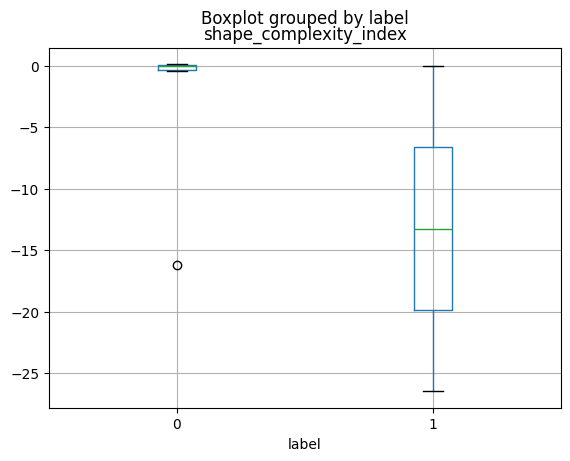

In [ ]:
# Boxplot by label
df.boxplot(column="shape_complexity_index", by="label")

In [ ]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(acc_com, acc_rad)

print("Wilcoxon p-value:", p)

Wilcoxon p-value: 1.0


/tmp/ipython-input-4225630768.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([acc_rad, acc_com], labels=["Radiomics", "Radiomics + Novel"])


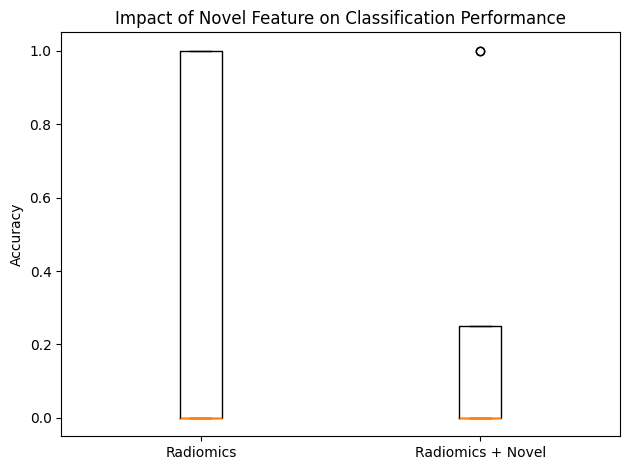

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([acc_rad, acc_com], labels=["Radiomics", "Radiomics + Novel"])
plt.ylabel("Accuracy")
plt.title("Impact of Novel Feature on Classification Performance")
plt.tight_layout()
plt.savefig("/content/novel_feature_ml_comparison.png")
plt.show()

**Validate correlations of ADI with label**

In [ ]:
numeric_df = df.select_dtypes(include=["number"])

In [ ]:
#Correlation with label
numeric_df[["label", "shape_complexity_index", "axis_disparity_index"]].corr()

,label,shape_complexity_index,axis_disparity_index
label,1.000000,-0.474352,-0.240898
shape_complexity_index,-0.474352,1.000000,0.381010
axis_disparity_index,-0.240898,0.381010,1.000000


In [ ]:
# Check redundancy (SCI vs ADI)
numeric_df[["shape_complexity_index", "axis_disparity_index"]].corr()

,shape_complexity_index,axis_disparity_index
shape_complexity_index,1.00000,0.38101
axis_disparity_index,0.38101,1.00000


In [ ]:
# Rank correlation against all features
numeric_df.corr()["axis_disparity_index"].sort_values(ascending=False)

,axis_disparity_index
axis_disparity_index,1.000000e+00
original_shape_VoxelVolume,6.627692e-01
original_shape_LeastAxisLength,4.077096e-01
shape_complexity_index,3.810104e-01
morphology_heterogeneity_score,3.713879e-01
axis_ratio,2.160598e-01
Shape_Complexity,2.160588e-01
original_shape_MinorAxisLength,9.302885e-02
original_shape_Flatness,1.471948e-02
original_shape_MajorAxisLength,3.422757e-16


**Fix evaluation properly (this is CRITICAL)**

**Leave-One-Out Cross Validation (LOOCV)**

In [ ]:
# Prepare data correctly
import pandas as pd
import numpy as np

from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
labels = {
    "TCGA-34-5241": 1,
    "TCGA-34-8455": 0,
    "TCGA-60-2695": 1,
    "TCGA-60-2696": 0,
    "TCGA-60-2710": 1,
    "TCGA-60-2711": 0,
    "TCGA-60-2716": 1,
    "TCGA-60-2721": 0
}

df["label"] = df["PatientID"].map(labels)

In [ ]:
print(df[["PatientID", "label"]])

      PatientID  label
0  TCGA-34-5241      1
1  TCGA-34-8455      0
2  TCGA-60-2695      1
3  TCGA-60-2696      0
4  TCGA-60-2710      1
5  TCGA-60-2711      0
6  TCGA-60-2716      1
7  TCGA-60-2721      0


In [ ]:
df = pd.read_csv("/content/lung_radiomics_novel.csv")

labels = {
    "TCGA-34-5241": 1,
    "TCGA-34-8455": 0,
    "TCGA-60-2695": 1,
    "TCGA-60-2696": 0,
    "TCGA-60-2710": 1,
    "TCGA-60-2711": 0,
    "TCGA-60-2716": 1,
    "TCGA-60-2721": 0
}

df["label"] = df["PatientID"].map(labels)

In [ ]:
print(df.columns.tolist())

['PatientID', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_MinorAxisLength', 'original_shape_VoxelVolume', 'Shape_Complexity', 'Elongation_Flatness_Ratio', 'Normalized_Lung_Size', 'Axis_Disparity', 'axis_ratio', 'shape_complexity_index', 'label']


In [ ]:
X_radiomics = df.drop(columns=["PatientID", "label"], errors="ignore")

X_radiomics_only = X_radiomics.drop(
    columns=["shape_complexity_index", "axis_disparity_index"],
    errors="ignore"
)

X_combined = X_radiomics
y = df["label"].values

In [ ]:
print(df.columns.tolist())

['PatientID', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_MinorAxisLength', 'original_shape_VoxelVolume', 'Shape_Complexity', 'Elongation_Flatness_Ratio', 'Normalized_Lung_Size', 'Axis_Disparity', 'axis_ratio', 'shape_complexity_index', 'label']


In [ ]:
required_cols = ["PatientID", "label"]
missing = [c for c in required_cols if c not in df.columns]
print("Missing columns:", missing)

Missing columns: []


In [ ]:
#Define LOOCV evaluation function
def loocv_evaluate(X, y):
    loo = LeaveOneOut()
    y_true, y_pred, y_prob = [], [], []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000))
        ])

        model.fit(X_train, y_train)

        y_true.append(y_test[0])
        y_pred.append(model.predict(X_test)[0])
        y_prob.append(model.predict_proba(X_test)[0, 1])

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    return acc, auc

In [ ]:
# Run proper evaluation
acc_rad, auc_rad = loocv_evaluate(X_radiomics_only, y)
acc_comb, auc_comb = loocv_evaluate(X_combined, y)

print(f"LOOCV Radiomics Accuracy: {acc_rad:.3f}")
print(f"LOOCV Radiomics AUC:      {auc_rad:.3f}\n")

print(f"LOOCV Combined Accuracy:  {acc_comb:.3f}")
print(f"LOOCV Combined AUC:       {auc_comb:.3f}")

LOOCV Radiomics Accuracy: 0.625
LOOCV Radiomics AUC:      0.812

LOOCV Combined Accuracy:  0.625
LOOCV Combined AUC:       0.812


In [1]:
!pip freeze > requirements.txt

In [2]:
!cat requirements.txt

absl-py==1.4.0
accelerate==1.12.0
access==1.1.10.post3
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.3
aiosignal==1.4.0
aiosqlite==0.22.1
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.18.4
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.1
anywidget==0.9.21
apsw==3.51.2.0
apswutils==0.1.2
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2026.2.23.0.48.33
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.8
autograd==1.8.0
babel==2.18.0
backcall==0.2.0
beartype==0.22.9
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.35.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.2.0
blosc2==4.0.0
bokeh==3.8.2
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.6
catalogue==2.0.10
certifi==2026.1.4
cf

In [3]:
!pip install nbconvert
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace FJ_update_2-4.ipynb

[NbConvertApp] WARNING | pattern 'FJ_update_2-4.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 